### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
import tensorflow
from collections import namedtuple, deque
import random
import torch.nn as nn
import torch.optim as optim
import torch
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from IPython import display
from datetime import datetime
from time import sleep

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
environment = UnityEnvironment(file_name="Banana/Banana.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        #self.weights = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
        #self.weights.append(args[3])
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
    def to(self, device):
        for transition in self.memory:
            for tensor in transition:
                tensor.to(device)

In [8]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_neurons=128):
        super(DQN, self).__init__()
        self.input = nn.Linear(n_observations, hidden_neurons)
        self.hidden = nn.Linear(hidden_neurons, hidden_neurons)
        #self.hidden2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.output = nn.Linear(hidden_neurons, n_actions)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        #x = F.relu(self.hidden2(x))
        return self.output(x)

In [9]:
class Agent():
    def __init__(self, env, batch_size=128, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, tau=0.005, lr=1e-4, memory_size=10000, hidden_neurons=128, update_every=1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.env = env        
        self.hidden_neurons = hidden_neurons
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        info = self.env.reset(train_mode=True)[self.brain_name]
        state = info.vector_observations[0]
        n_actions = self.brain.vector_action_space_size
        n_observation = len(state)
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.tau = tau
        self.update_every = update_every
        self.episode_rewards = [] 
        self.lr = lr
        self.policy_net = DQN(n_observation, n_actions, self.hidden_neurons)
        self.policy_net.to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(memory_size)
        self.steps_done = 0
        self.target_net = DQN(n_observation, n_actions, self.hidden_neurons)
        self.target_net.to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
       
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1 * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1,1)
        else:
            return torch.tensor([random.sample(range(0,4), 1)], device=self.device, dtype=torch.long)
        
    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_rewards, dtype=torch.float)
        if show_result:
            plt.title("Result")
        else:
            plt.clf()
            plt.title("Training...")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(durations_t.numpy())
        if len(durations_t) >= 100:
            means = durations_t.unfold(0,100,1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())
        plt.axhline(y=13, color='r')
        plt.pause(0.001)
        if not show_result:
            display.display(plt.gcf());
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf());
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_batch = torch.cat(batch.next_state)
        #state_action_values = self.policy_net(state_batch).gather(2, action_batch.unsqueeze(1))
        state_action_values = torch.max(self.policy_net(state_batch), 2)[0]
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values = self.target_net(next_batch).max(1)[0]
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
    def train(self, num_episodes=1000):
        for _ in range(num_episodes):
            info = self.env.reset(train_mode=True)[self.brain_name]
            state = info.vector_observations[0]
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            episode_reward = 0
            while True:
                action = self.select_action(state)
                info = self.env.step(int(action))[self.brain_name]
                next_state = info.vector_observations[0]
                reward = info.rewards[0]
                episode_reward += reward
                done = info.local_done[0]
                reward = torch.tensor([reward], device=self.device)
                
                next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device).unsqueeze(0)
                state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                #action = torch.tensor(action, dtype=torch.int64, device=self.device).unsqueeze(0)
                self.memory.push(state,action, next_state, reward)

                state = next_state

                if self.steps_done % self.update_every == 0:
                    self.optimize_model()

                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                #if self.steps_done % (1/self.tau) == 0:
                #    self.target_net.load_state_dict(self.policy_net.state_dict())

                if done:
                    self.episode_rewards.append(episode_reward)
                    self.plot_durations()
                    break
        print('Complete')
        self.plot_durations(show_result=True)
        plt.ioff()
        plt.show();
        
    def save(self, filename=None):
        print("Saving...")
        if filename is None:
            filename = "./model_" + datetime.now().strftime("%Y%m%d_%H%M") + ".pth"
        torch.save({
                'policy_net_state_dict': self.policy_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'batch_size': self.batch_size,
                'gamma': self.gamma,
                'eps_start': self.eps_start,
                'eps_end': self.eps_end,
                'eps_decay': self.eps_decay,
                'tau': self.tau,
                'episode_rewards': self.episode_rewards,
                'memory': self.memory,
                'steps_done': self.steps_done,
                'lr': self.lr,
                'hidden_neurons': self.hidden_neurons
            }, filename)
        print(f"Model saved to {filename}")

    def load(self, filename):
        print(f"Loading model {filename}")
        config = torch.load(filename, map_location=torch.device("cpu").type)
        self.policy_net.load_state_dict(config["policy_net_state_dict"])
        self.policy_net.to(self.device)
        self.optimizer.load_state_dict(config["optimizer_state_dict"])
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]
        self.eps_start = config["eps_start"]
        self.eps_end = config["eps_end"]
        self.eps_decay = config["eps_decay"]
        self.tau = config["tau"]
        self.episode_rewards = config["episode_rewards"]
        self.memory = config["memory"]
        self.lr = config["lr"]
        self.memory.to(self.device)
        self.steps_done = config["steps_done"]
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.to(self.device)

In [10]:
agent = Agent(environment)

KeyboardInterrupt: 

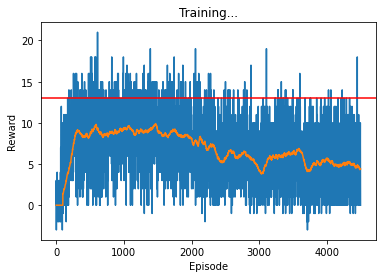

In [15]:
%%capture --no-display
filename = "model1.pth"
agent.load(filename)
agent.lr = 1e-4
try:
    while True:
        agent.train(500)
        agent.save(filename)
finally:
    agent.save(filename)

In [ ]:
transitions = agent.memory.sample(agent.batch_size)
batch = Transition(*zip(*transitions))
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
next_batch = torch.cat(batch.next_state)

In [ ]:
agent.policy_net(state_batch).shape

torch.Size([128, 1, 4])

In [ ]:
action_batch.unsqueeze(1).shape

torch.Size([128, 1, 1])

In [ ]:
agent.policy_net(state_batch).gather(2, action_batch.unsqueeze(1))

tensor([[[ 2.0274]],

        [[ 1.8009]],

        [[ 1.0672]],

        [[ 1.4209]],

        [[ 1.6835]],

        [[ 2.8674]],

        [[ 1.1630]],

        [[ 2.4487]],

        [[ 2.4569]],

        [[ 1.7168]],

        [[ 1.3255]],

        [[ 1.9042]],

        [[ 1.5935]],

        [[ 1.3856]],

        [[ 2.4793]],

        [[ 1.6784]],

        [[ 1.5149]],

        [[ 1.6144]],

        [[ 0.5290]],

        [[ 2.6444]],

        [[ 2.5171]],

        [[ 1.5716]],

        [[ 2.4631]],

        [[ 2.1324]],

        [[ 2.8254]],

        [[ 2.3340]],

        [[ 1.7705]],

        [[ 1.5746]],

        [[ 1.8811]],

        [[ 1.6946]],

        [[ 1.6922]],

        [[ 1.6769]],

        [[ 1.5648]],

        [[ 0.3841]],

        [[ 1.6346]],

        [[ 2.6931]],

        [[-1.1712]],

        [[ 1.9579]],

        [[ 1.5058]],

        [[ 1.3613]],

        [[ 1.4581]],

        [[ 1.3593]],

        [[ 1.3963]],

        [[ 1.6367]],

        [[ 1.6922]],

        [[

In [ ]:
agent.policy_net(state_batch)

tensor([[[ 2.0274e+00,  2.8013e-01,  1.4149e+00, -1.0236e+00]],

        [[ 1.5846e+00,  1.4660e+00,  1.8009e+00, -1.0691e+00]],

        [[ 1.0672e+00,  1.0091e+00, -6.1317e-01, -4.1920e-01]],

        [[ 1.5027e+00,  1.4209e+00,  5.0773e-01, -7.8916e-01]],

        [[ 1.6835e+00,  1.2602e+00,  1.5284e+00, -6.6846e-01]],

        [[ 2.8674e+00, -1.5503e-01,  1.7513e+00, -1.4482e+00]],

        [[ 1.7720e+00,  1.1630e+00,  8.9331e-01, -9.0329e-01]],

        [[ 2.4487e+00, -1.0330e+00, -1.2747e+00, -1.3621e+00]],

        [[ 2.4569e+00, -3.5724e-01, -5.6432e-01, -1.1987e+00]],

        [[ 1.7168e+00,  2.2933e-03, -2.2989e-01, -1.1900e+00]],

        [[ 1.3218e+00,  1.3255e+00,  1.0797e+00, -3.9888e-01]],

        [[ 1.6237e+00,  1.3657e+00,  1.9042e+00, -7.1986e-01]],

        [[ 1.4166e+00,  1.5935e+00,  1.0443e+00, -2.7608e-01]],

        [[ 1.3856e+00,  1.3105e+00,  1.0963e+00, -2.8390e-01]],

        [[ 2.4793e+00, -2.3651e+00, -1.6910e+00, -1.0670e+00]],

        [[ 1.6784e+00,  1

In [ ]:
action_batch

tensor([[0],
        [2],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [1],
        [0],
        [0],
        [2],
        [0],
        [0],
        [3],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [3],
        [2],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [1],
        [1],
        [0],
        [1],

In [ ]:
agent.policy_net(state_batch).gather(2, action_batch)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
def details(filename):
    config = torch.load(filename, map_location=torch.device("cpu"))
    agent.episode_rewards = config["episode_rewards"]
    agent.plot_durations(show_result=True)
    del config["policy_net_state_dict"]
    del config["optimizer_state_dict"]
    del config["memory"]
    del config["episode_rewards"]
    print(config)

In [ ]:
environment.close()